# 데이콘 쇼핑몰 지점별 매출액 예측


- 참고 코드 : https://dacon.io/competitions/official/235942/codeshare/5984?page=1&dtype=recent

In [1]:
# !pip install catboost

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

## 1. 데이터 불러오기 및 확인

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train.tail()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20
6254,6255,45,28/09/2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,8.684,False,713173.95


## 2. date => 연, 월, 일로 나누기

In [4]:
def date_encoder(date):
    day, month, year = map(int, date.split('/'))
    return day, month, year

train['Day'] = train['Date'].apply(lambda x : date_encoder(x)[0])
train['Month'] = train['Date'].apply(lambda x: date_encoder(x)[1])
train['Year'] = train['Date'].apply(lambda x: date_encoder(x)[2])

test['Day'] = test['Date'].apply(lambda x : date_encoder(x)[0])
test['Month'] = test['Date'].apply(lambda x: date_encoder(x)[1])
test['Year'] = test['Date'].apply(lambda x: date_encoder(x)[2])

train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90,5,2,2010
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44,12,2,2010
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17,19,2,2010
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59,26,2,2010
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,31,8,2012
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,7,9,2012
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27,14,9,2012
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,21,9,2012


In [5]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales,Day,Month,Year
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06,15.683453,6.345324,2010.935252
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05,8.781023,3.227195,0.788547
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05,1.000000,1.000000,2010.000000
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05,8.000000,4.000000,2010.000000
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05,16.000000,6.000000,2011.000000
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06,23.000000,9.000000,2012.000000
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06,31.000000,12.000000,2012.000000


- Promotion의 값들의 편차가 매우 큼
- Promotion2와 Promotion3에서 음수값 존재
- Promotion에 대한 해석이 다양할 수 있고, 음수값을 처리할만한 충분한 근거가 없음

## 결측치 확인

In [6]:
def check_missing_col(df):
    missing_col = []
    counted_missing_col = 0

    for i, col in enumerate(df.columns):
        missing_values = sum(df[col].isna())    #컬럼별 결측치 총개수
        is_missing = True if missing_values >= 1 else False

        if is_missing :
            counted_missing_col += 1
            print(f'결측치가 있는 칼럼은: {col}이다.')
            print(f'해당 칼럼에 총 {missing_values}개의 결측치가 있다.')
            missing_col.append([col, df[col].dtype])

    if counted_missing_col == 0:
        print('결측치 없음')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 칼럼은: Promotion1이다.
해당 칼럼에 총 4153개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion2이다.
해당 칼럼에 총 4663개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion3이다.
해당 칼럼에 총 4370개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion4이다.
해당 칼럼에 총 4436개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion5이다.
해당 칼럼에 총 4140개의 결측치가 있다.


In [7]:
missing_col = check_missing_col(test)

결측치가 있는 칼럼은: Promotion1이다.
해당 칼럼에 총 2개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion2이다.
해당 칼럼에 총 135개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion3이다.
해당 칼럼에 총 19개의 결측치가 있다.
결측치가 있는 칼럼은: Promotion4이다.
해당 칼럼에 총 34개의 결측치가 있다.


- train, test 데이터 모두 Promotion들에만 결측치가 있음.
- 아래를 보면, 2011/11/11부터 프로모션 데이터가 들어가 있음 => 이때부터 기록된 것으로 판단
- 간단하게, 모든 결측치를 0으로 채우기로 함

In [8]:
train[train['Promotion1'].isnull()]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90,5,2,2010
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44,12,2,2010
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17,19,2,2010
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59,26,2,2010
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6203,6204,45,07/10/2011,55.82,3.583,NaN,NaN,NaN,NaN,NaN,8.523,False,753447.05,7,10,2011
6204,6205,45,14/10/2011,63.82,3.541,NaN,NaN,NaN,NaN,NaN,8.523,False,720946.99,14,10,2011
6205,6206,45,21/10/2011,59.60,3.570,NaN,NaN,NaN,NaN,NaN,8.523,False,771686.40,21,10,2011
6206,6207,45,28/10/2011,51.78,3.569,NaN,NaN,NaN,NaN,NaN,8.523,False,781694.57,28,10,2011


In [9]:
train[train['Promotion1'].notnull()]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
92,93,1,11/11/2011,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,7.866,False,1594938.89,11,11,2011
93,94,1,18/11/2011,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,7.866,False,1539483.70,18,11,2011
94,95,1,25/11/2011,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,7.866,True,2033320.66,25,11,2011
95,96,1,02/12/2011,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,7.866,False,1584083.95,2,12,2011
96,97,1,09/12/2011,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,7.866,False,1799682.38,9,12,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,31,8,2012
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,7,9,2012
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27,14,9,2012
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,21,9,2012


In [10]:
Promotion_list = ['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5']

for i in Promotion_list:
    train[i].fillna(0, inplace = True)

for i in Promotion_list:
    test[i].fillna(0, inplace = True)

In [11]:
missing_col = check_missing_col(train)
missing_col = check_missing_col(test)

결측치 없음
결측치 없음


- 11, 12월엔 이벤트가 많으니 극단값을 가짐(확인) => 따라서 10월까지만 데이터를 씀

In [12]:
# 2010~2011년 데이터로 2012년! 예측해보는 것
train = train[train['Month']<= 10]
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Day,Month,Year
0,1,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90,5,2,2010
1,2,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44,12,2,2010
2,3,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17,19,2,2010
3,4,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59,26,2,2010
4,5,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,31,8,2012
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,7,9,2012
6252,6253,45,14/09/2012,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27,14,9,2012
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,21,9,2012


### 지점별 주간 매출액 합 비교

In [13]:
train_max_store_sum = train.groupby('Store')[['Weekly_Sales']].sum()
train_max_store_sum

,Weekly_Sales
Store,
1,1.848972e+08
2,2.269652e+08
3,4.748683e+07
4,2.467096e+08
5,3.751943e+07
6,1.846262e+08
7,6.717649e+07
8,1.072669e+08
9,6.403729e+07


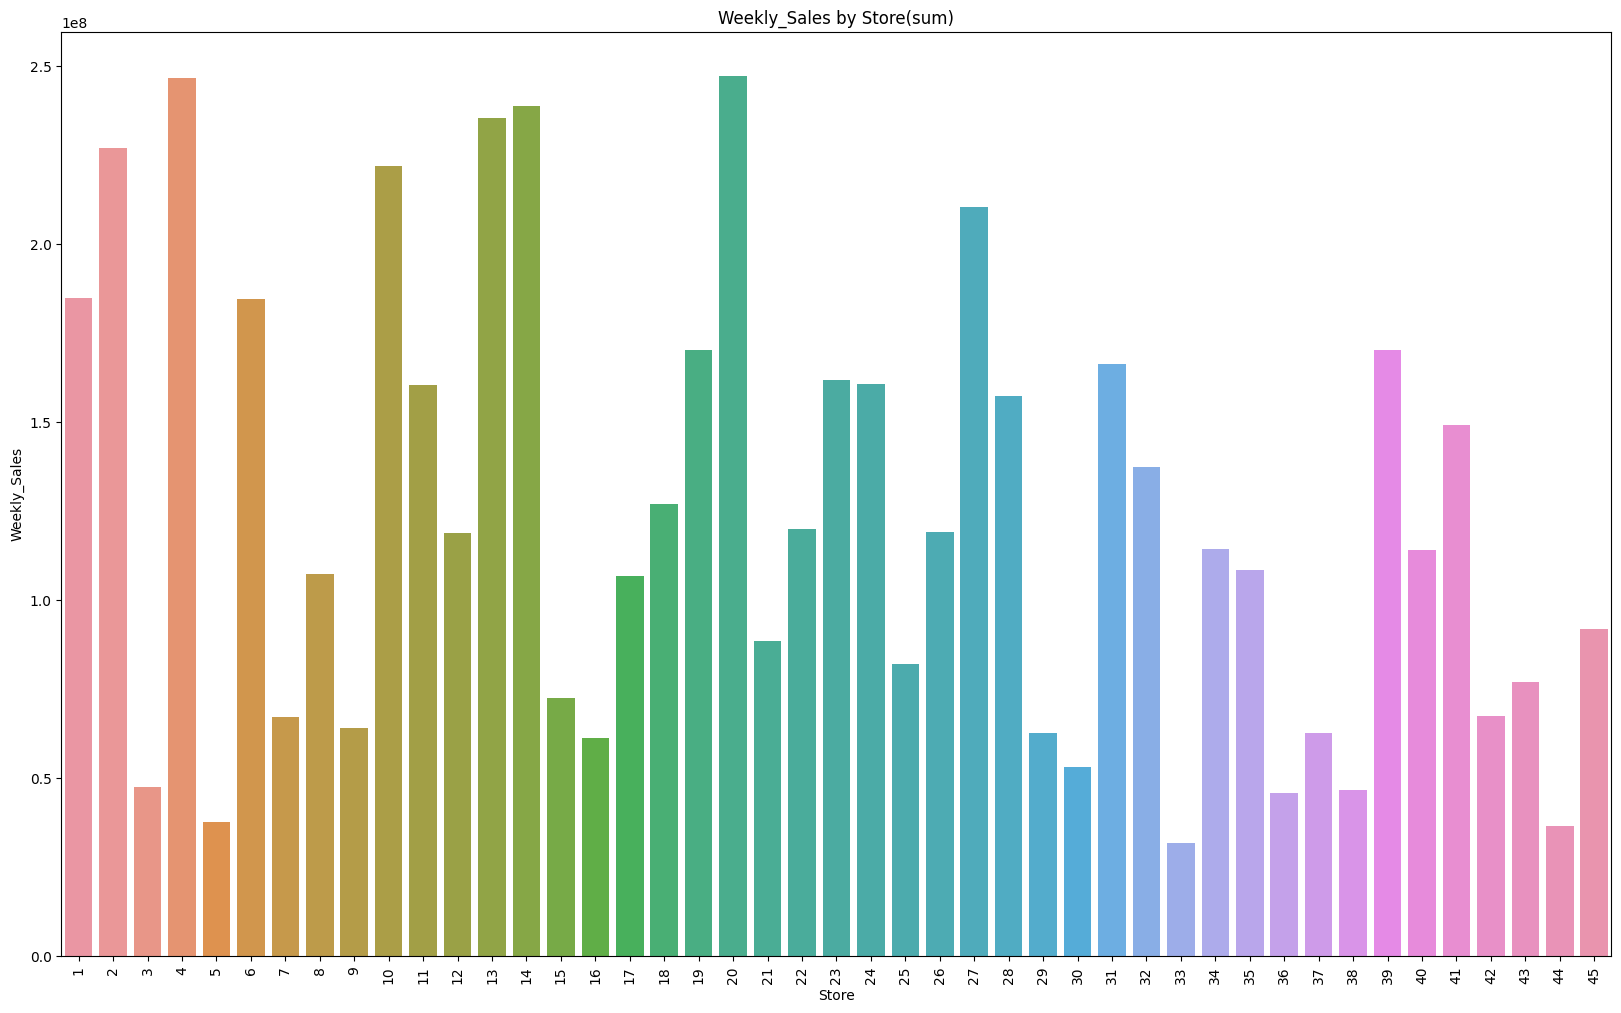

In [14]:
fig = plt.figure(figsize = (20, 12))
sns.barplot(x = train_max_store_sum.index, y = train_max_store_sum['Weekly_Sales'])
plt.title('Weekly_Sales by Store(sum)')
plt.xticks(rotation = 90)
plt.show()

- 지점별로 매출액 차이 큼 => 지점별 예측이 필요하지 않을까?
- 지점별 매출액과 변수들의 상관관계 확인 필요

### 지점별 매출액과 변수들의 상관관계 확인

In [15]:
corr = []
for num in range(1, 46):
    co = train[train.Store == num]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['index', 'id','Store','Weekly_Sales'])
    corr.append(num_corr)

corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1, 46))
corr_df

,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Day,Month,Year
1,-0.073521,0.319477,0.446456,0.171138,0.200067,0.346576,0.364598,-0.346391,0.225881,-0.564823,-0.161372,0.388406
2,-0.151176,-0.196541,0.193960,0.023742,0.053809,0.190185,0.128038,0.006770,0.211216,-0.432645,-0.257000,-0.062514
3,-0.282653,0.364180,0.560730,0.124942,0.174523,0.406714,0.574019,-0.479790,0.124544,-0.360338,-0.313120,0.554708
4,0.048495,0.598568,0.468183,0.112282,0.219819,0.375327,0.554521,-0.674596,0.158430,-0.209892,-0.057255,0.702947
5,0.028074,0.444613,0.453364,0.072304,0.230470,0.295104,0.538058,-0.557376,0.143597,-0.361627,-0.151100,0.546554
6,0.244030,0.005705,0.160261,-0.081688,0.161620,0.120742,0.099024,-0.075521,0.022316,-0.358076,-0.081668,0.011136
7,0.338380,0.278150,0.111396,0.203127,0.045791,0.153901,0.207047,-0.419651,0.027623,-0.138447,0.104944,0.440637
8,-0.177507,0.260307,0.287882,0.086949,0.109161,0.269410,0.031546,-0.295658,0.197459,-0.392509,-0.224594,0.323072
9,0.039240,0.529408,0.413207,0.189591,0.128380,0.295595,0.417826,-0.464455,0.112805,-0.292811,-0.109886,0.533507
10,-0.401473,-0.187480,0.076778,-0.043714,0.011454,0.066849,0.082047,0.242537,0.172861,-0.248658,-0.450791,-0.126476


### 각 매장별 매출과 다른 변수들의 상관관계 시각화

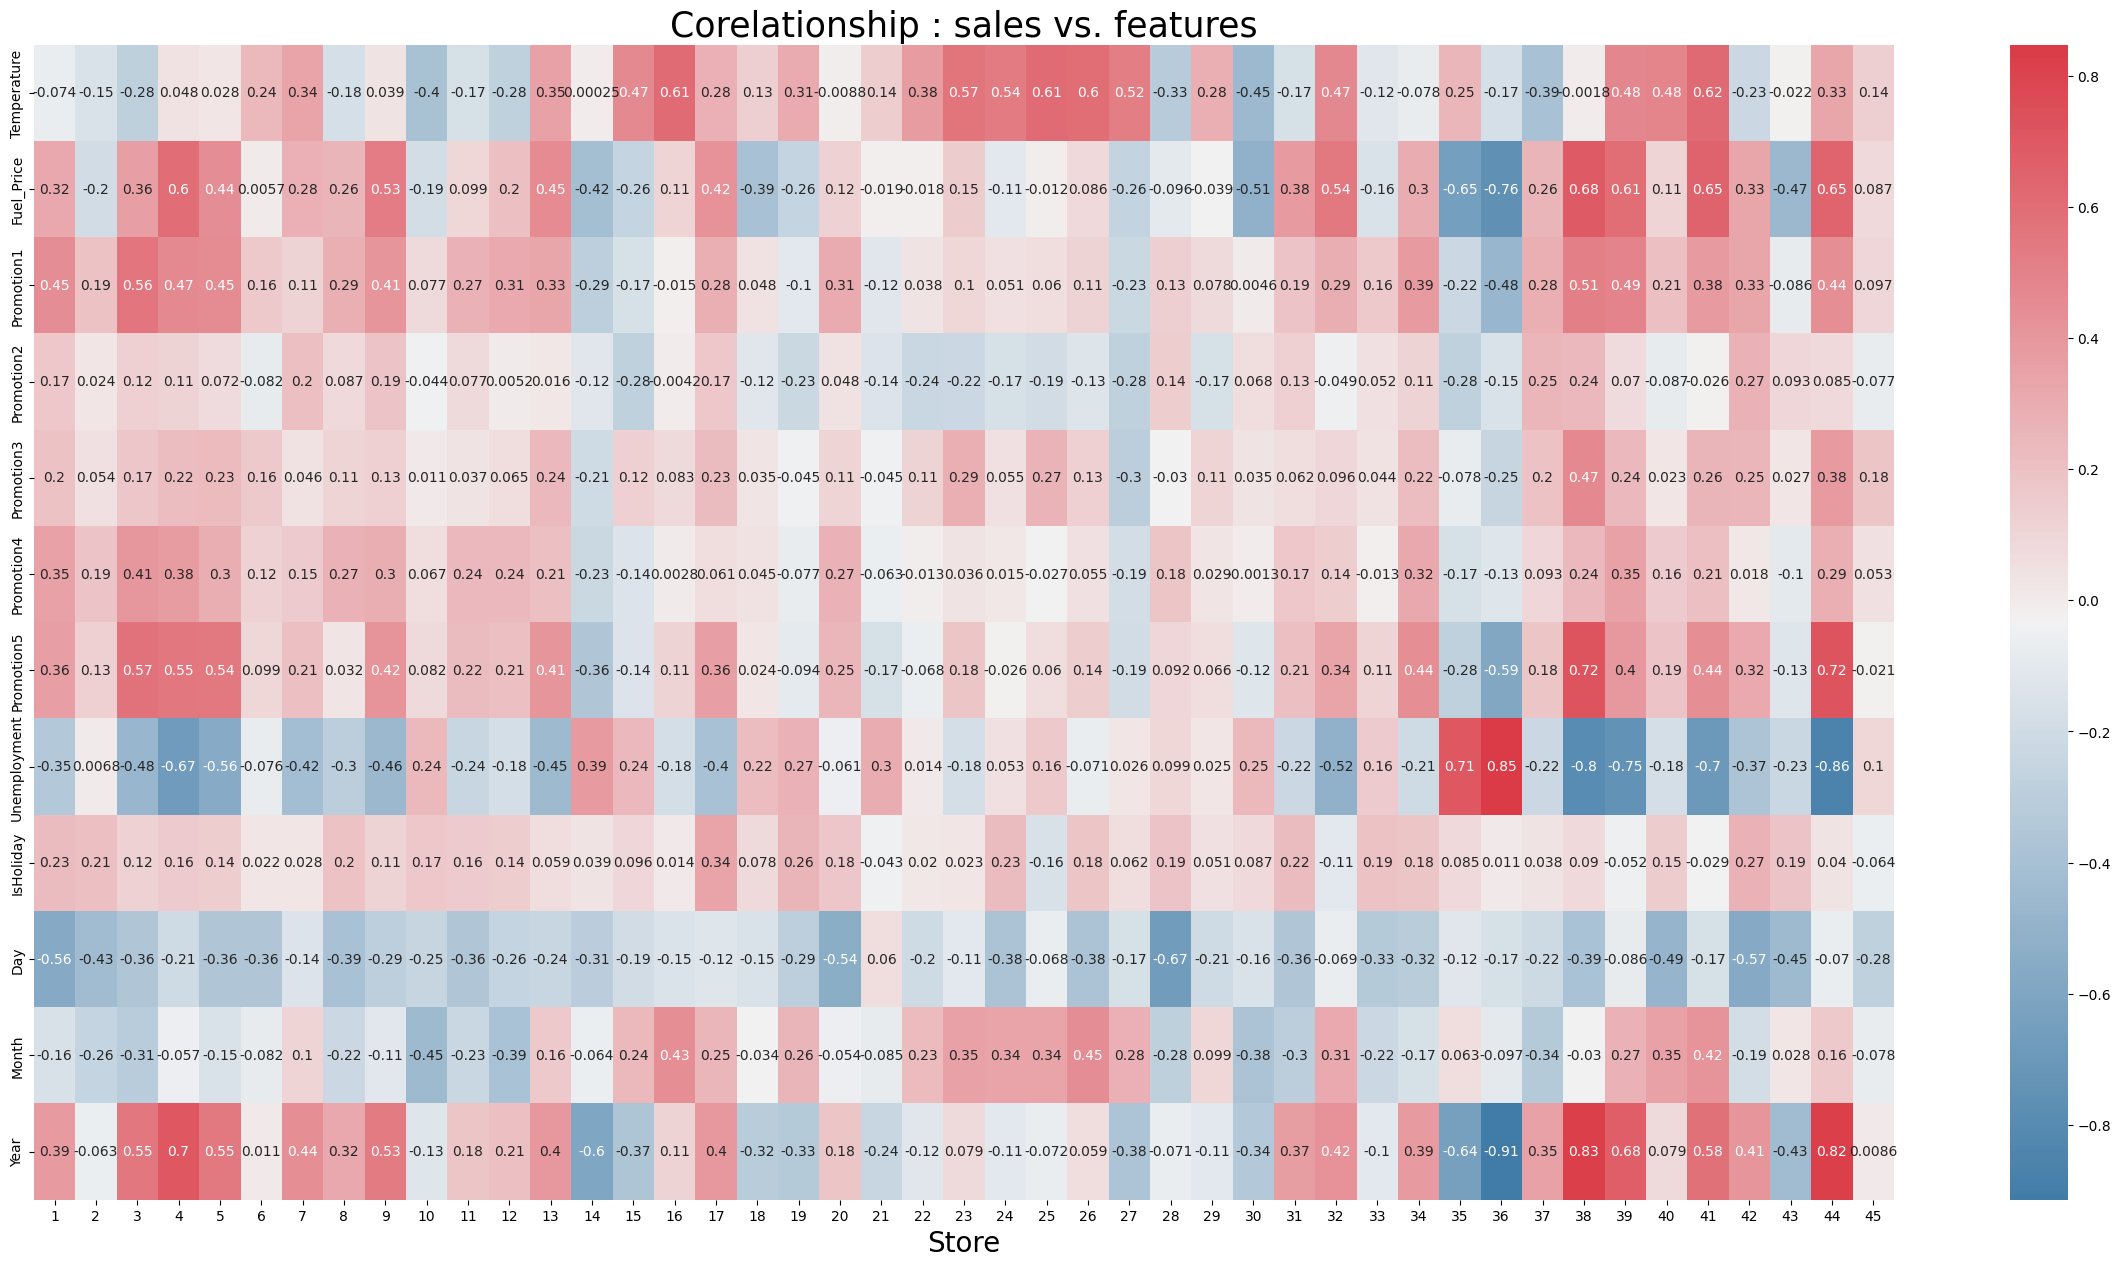

In [16]:
fig, ax = plt.subplots(figsize = (30, 15))
plt.title('Corelationship : sales vs. features', fontsize = 25)
sns.heatmap(corr_df.T, cmap = sns.diverging_palette(240, 10, as_cmap=True), ax = ax, annot = True)
plt.xlabel('Store',  fontsize = 20)
plt.show()

In [17]:
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

### 매장별로 Promotion 과의 상관계수 중 0.4이상인 피쳐만 선택
- 지점별로 변수들과의 상관계수가 다름
- 상관관계를 통한 Feature Selection 진행 : 프로모션 중심으로

### Feature selection 및 하이퍼 파라미터 설정
- Temperature, Fuel_Price, Unemployment 는 모델의 성능 향상에 좋은 영향을 끼치지 못한 것으로 판단
- 모든 Promotion을 Feature에 넣어주는 것 또한 모델의 성능 향상에 좋은 영향을 끼치지 못함.
- -> 따라서 상관관계를 통해 selct한 Feature들을 각 모델마다 넣어줌

In [18]:
# Store별로 나눠서 모델을 돌리기로 함 =>> feature에 Store 있으나 없으나 같으므로 제거.

features = ['IsHoliday','Month','Year','Day']
features_1_3_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion3','Promotion5']
features_1_4_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion4','Promotion5']
features_1_5 = ['IsHoliday','Month','Year','Day','Promotion1','Promotion5']
features_1 = ['IsHoliday','Month','Year','Day','Promotion1']
features_5 = ['IsHoliday','Month','Year','Day','Promotion5']

# 하이퍼 파라미터 설정
model_params = {
    'n_estimators':3300,
    'max_depth':3,
    'learning_rate':0.01
}

## 모델링 : CatBoost 사용
### 지점별 모델 학습
- 위에서 지점별, 프로모션과 매출 상관관계가 0.4 이상인 것들을 분류

In [21]:
models = []

for store in range(1, max(train.Store)+1):
    if (store == 38):
        train_store = train[train.Store == store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features_1_3_5], train_store.Weekly_Sales)
        models.append(model)

    elif (store == 3):
        train_store = train[train.Store == store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features_1_4_5], train_store.Weekly_Sales)
        models.append(model)

    elif (store == 4 or store == 5 or store == 9 or store == 44):
        train_store = train[train.Store==store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features_1_5], train_store.Weekly_Sales)
        models.append(model)

    elif (store == 1 or store == 39):
        train_store = train[train.Store==store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features_1], train_store.Weekly_Sales)
        models.append(model)

    elif (store == 13 or store == 34 or store == 41):
        train_store = train[train.Store==store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features_5], train_store.Weekly_Sales)
        models.append(model)

    else:
        train_store = train[train.Store==store]
        model = CatBoostRegressor(**model_params)
        model.fit(train_store[features], train_store.Weekly_Sales)
        models.append(model)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1600:	learn: 5131.7329479	total: 569ms	remaining: 604ms
1601:	learn: 5129.9206434	total: 569ms	remaining: 603ms
1602:	learn: 5128.9304327	total: 570ms	remaining: 603ms
1603:	learn: 5128.4879477	total: 570ms	remaining: 603ms
1604:	learn: 5127.5842114	total: 571ms	remaining: 603ms
1605:	learn: 5127.3782594	total: 571ms	remaining: 602ms
1606:	learn: 5126.4614467	total: 571ms	remaining: 602ms
1607:	learn: 5125.6644934	total: 572ms	remaining: 602ms
1608:	learn: 5124.6555921	total: 572ms	remaining: 601ms
1609:	learn: 5123.9773005	total: 573ms	remaining: 601ms
1610:	learn: 5123.0064971	total: 573ms	remaining: 601ms
1611:	learn: 5120.8247433	total: 574ms	remaining: 601ms
1612:	learn: 5120.1219524	total: 574ms	remaining: 600ms
1613:	learn: 5119.4041973	total: 574ms	remaining: 600ms
1614:	learn: 5118.1681330	total: 575ms	remaining: 600ms
1615:	learn: 5116.4242683	total: 575ms	remaining: 599ms
1616:	learn: 5116.0034849	total: 576ms	remaining: 599ms
1617:	learn:

In [23]:
pred = []

for store in range(1, max(test.Store)+1):
    if (store == 38):
        test_store = test[test.Store == store]
        y_pred = models[store-1].predict(test_store[features_1_3_5])
        pred += y_pred.tolist()

    elif (store == 3):
        test_store = test[test.Store==store]
        y_pred = models[store-1].predict(test_store[features_1_4_5])
        pred += y_pred.tolist()

    elif (store == 4 or store == 5 or store == 9 or store == 44):
        test_store = test[test.Store==store]
        y_pred = models[store-1].predict(test_store[features_1_5])
        pred += y_pred.tolist()

    elif (store == 1 or store == 39 ):
        test_store = test[test.Store==store]
        y_pred = models[store-1].predict(test_store[features_1])
        pred += y_pred.tolist()

    elif (store == 13 or store == 34 or store == 41):
        test_store = test[test.Store==store]
        y_pred = models[store-1].predict(test_store[features_5])
        pred += y_pred.tolist()

    else:
        test_store = test[test.Store==store]
        y_pred = models[store-1].predict(test_store[features])
        pred += y_pred.tolist()

### 결과 저장

In [27]:
sample_submission['Weekly_Sales'] = pred
# submission.to_csv('vacation_submission_final.csv', index=False)
# submission

In [28]:
sample_submission

,id,Weekly_Sales
0,1,1.690753e+06
1,2,1.549697e+06
2,3,1.524767e+06
3,4,1.461611e+06
4,5,1.920476e+06
...,...,...
175,176,3.513331e+05
176,177,7.698146e+05
177,178,7.347854e+05
178,179,7.366956e+05
